# Optimizer Comparison for Half-Moons Classification
## Comparing Adam, AdamW, SGD, RMSprop, and Adagrad

## Step 1: Import Required Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from matplotlib.patches import Patch
import time

np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.8.0+cpu
Device: cpu


## Step 2: Data Loading and Preparation

In [30]:
data = pd.read_csv('c:/Users/latik/Downloads/2halfmoonsTrain.csv')

X = data[['X', 'Y']].values
y = data['ClassLabel'].values
y = y - 1

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

print(f"Dataset shape: {data.shape}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Dataset shape: (800, 3)
Training samples: 640
Validation samples: 160


## Step 3: Define MLP Model

In [31]:
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=16, output_size=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

print("Model architecture: 2 -> 16 (ReLU) -> 1 (Sigmoid)")
print(f"Total parameters: {sum(p.numel() for p in MLP().parameters())}")

Model architecture: 2 -> 16 (ReLU) -> 1 (Sigmoid)
Total parameters: 65


## Step 4: Training Function

In [32]:
def train_model(model, optimizer, criterion, num_epochs=2000, verbose=True):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        outputs_train = model(X_train_tensor)
        loss_train = criterion(outputs_train, y_train_tensor)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        predictions_train = (outputs_train >= 0.5).float()
        train_acc = (predictions_train == y_train_tensor).float().mean().item()
        
        train_losses.append(loss_train.item())
        train_accs.append(train_acc)
        
        model.eval()
        with torch.no_grad():
            outputs_val = model(X_val_tensor)
            loss_val = criterion(outputs_val, y_val_tensor)
            predictions_val = (outputs_val >= 0.5).float()
            val_acc = (predictions_val == y_val_tensor).float().mean().item()
            
            val_losses.append(loss_val.item())
            val_accs.append(val_acc)
        
        if verbose and (epoch + 1) % 500 == 0:
            print(f"  Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {loss_train.item():.4f}, Train Acc: {train_acc*100:.2f}% | "
                  f"Val Loss: {loss_val.item():.4f}, Val Acc: {val_acc*100:.2f}%")
    
    training_time = time.time() - start_time
    
    return train_losses, val_losses, train_accs, val_accs, training_time

## Step 5: Configure All Optimizers

In [33]:
criterion = nn.BCELoss()
num_epochs = 2000

optimizer_configs = {
    'Adam': {
        'class': optim.Adam,
        'params': {'lr': 0.001, 'weight_decay': 1e-5},
        'color': 'blue'
    },
    'AdamW': {
        'class': optim.AdamW,
        'params': {'lr': 0.001, 'weight_decay': 1e-5},
        'color': 'green'
    },
    'SGD': {
        'class': optim.SGD,
        'params': {'lr': 0.1, 'momentum': 0.9, 'weight_decay': 1e-5},
        'color': 'red'
    },
    'RMSprop': {
        'class': optim.RMSprop,
        'params': {'lr': 0.01, 'alpha': 0.99, 'weight_decay': 1e-5},
        'color': 'orange'
    },
    'Adagrad': {
        'class': optim.Adagrad,
        'params': {'lr': 0.01, 'weight_decay': 1e-5},
        'color': 'purple'
    }
}

print("Optimizer Configurations:")
print("="*60)
for name, config in optimizer_configs.items():
    print(f"{name:12s}: {config['params']}")
print("="*60)

Optimizer Configurations:
Adam        : {'lr': 0.001, 'weight_decay': 1e-05}
AdamW       : {'lr': 0.001, 'weight_decay': 1e-05}
SGD         : {'lr': 0.1, 'momentum': 0.9, 'weight_decay': 1e-05}
RMSprop     : {'lr': 0.01, 'alpha': 0.99, 'weight_decay': 1e-05}
Adagrad     : {'lr': 0.01, 'weight_decay': 1e-05}


## Step 6: Train All Optimizers

In [34]:
results = {}

print("TRAINING ALL OPTIMIZERS")
print("="*60 + "\n")

for optimizer_name, config in optimizer_configs.items():
    print(f"Training with {optimizer_name}...")
    print(f"{'='*60}")

    torch.manual_seed(42)

    model = MLP()

    optimizer = config['class'](model.parameters(), **config['params'])
    
    train_losses, val_losses, train_accs, val_accs, training_time = train_model(
        model, optimizer, criterion, num_epochs, verbose=True
    )
    
    results[optimizer_name] = {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'training_time': training_time,
        'final_train_acc': train_accs[-1],
        'final_val_acc': val_accs[-1],
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'color': config['color']
    }
    
    print(f"\n{optimizer_name} Training Complete!")
    print(f"  Time: {training_time:.2f}s")
    print(f"  Final Train Acc: {train_accs[-1]*100:.2f}%")
    print(f"  Final Val Acc: {val_accs[-1]*100:.2f}%")

print("\n" + "="*60)
print("ALL TRAINING COMPLETED!")


TRAINING ALL OPTIMIZERS

Training with Adam...
  Epoch [500/2000] - Train Loss: 0.2251, Train Acc: 91.09% | Val Loss: 0.2263, Val Acc: 90.00%
  Epoch [500/2000] - Train Loss: 0.2251, Train Acc: 91.09% | Val Loss: 0.2263, Val Acc: 90.00%
  Epoch [500/2000] - Train Loss: 0.2251, Train Acc: 91.09% | Val Loss: 0.2263, Val Acc: 90.00%
  Epoch [1000/2000] - Train Loss: 0.1706, Train Acc: 91.87% | Val Loss: 0.1576, Val Acc: 94.38%
  Epoch [1000/2000] - Train Loss: 0.1706, Train Acc: 91.87% | Val Loss: 0.1576, Val Acc: 94.38%
  Epoch [1000/2000] - Train Loss: 0.1706, Train Acc: 91.87% | Val Loss: 0.1576, Val Acc: 94.38%
  Epoch [1500/2000] - Train Loss: 0.1362, Train Acc: 93.12% | Val Loss: 0.1195, Val Acc: 94.38%
  Epoch [1500/2000] - Train Loss: 0.1362, Train Acc: 93.12% | Val Loss: 0.1195, Val Acc: 94.38%
  Epoch [1500/2000] - Train Loss: 0.1362, Train Acc: 93.12% | Val Loss: 0.1195, Val Acc: 94.38%
  Epoch [2000/2000] - Train Loss: 0.1013, Train Acc: 95.16% | Val Loss: 0.0852, Val Acc: 98.

## Step 7: Performance Comparison Table

In [35]:
print("OPTIMIZER PERFORMANCE COMPARISON")
print("="*80)
print(f"{'Optimizer':<12} {'Train Acc':<12} {'Val Acc':<12} {'Train Loss':<12} {'Val Loss':<12} {'Time (s)':<10}")
print("-"*80)

for name, res in results.items():
    print(f"{name:<12} {res['final_train_acc']*100:>10.2f}% {res['final_val_acc']*100:>10.2f}% "
          f"{res['final_train_loss']:>11.4f} {res['final_val_loss']:>11.4f} {res['training_time']:>9.2f}")

OPTIMIZER PERFORMANCE COMPARISON
Optimizer    Train Acc    Val Acc      Train Loss   Val Loss     Time (s)  
--------------------------------------------------------------------------------
Adam              95.16%      98.75%      0.1013      0.0852      1.80
AdamW             95.16%      98.75%      0.1012      0.0851      2.45
SGD              100.00%     100.00%      0.0047      0.0027      1.40
RMSprop          100.00%     100.00%      0.0028      0.0009      1.75
Adagrad           91.56%      94.38%      0.1748      0.1634      1.83


## Step 8: Comparative Learning Curves

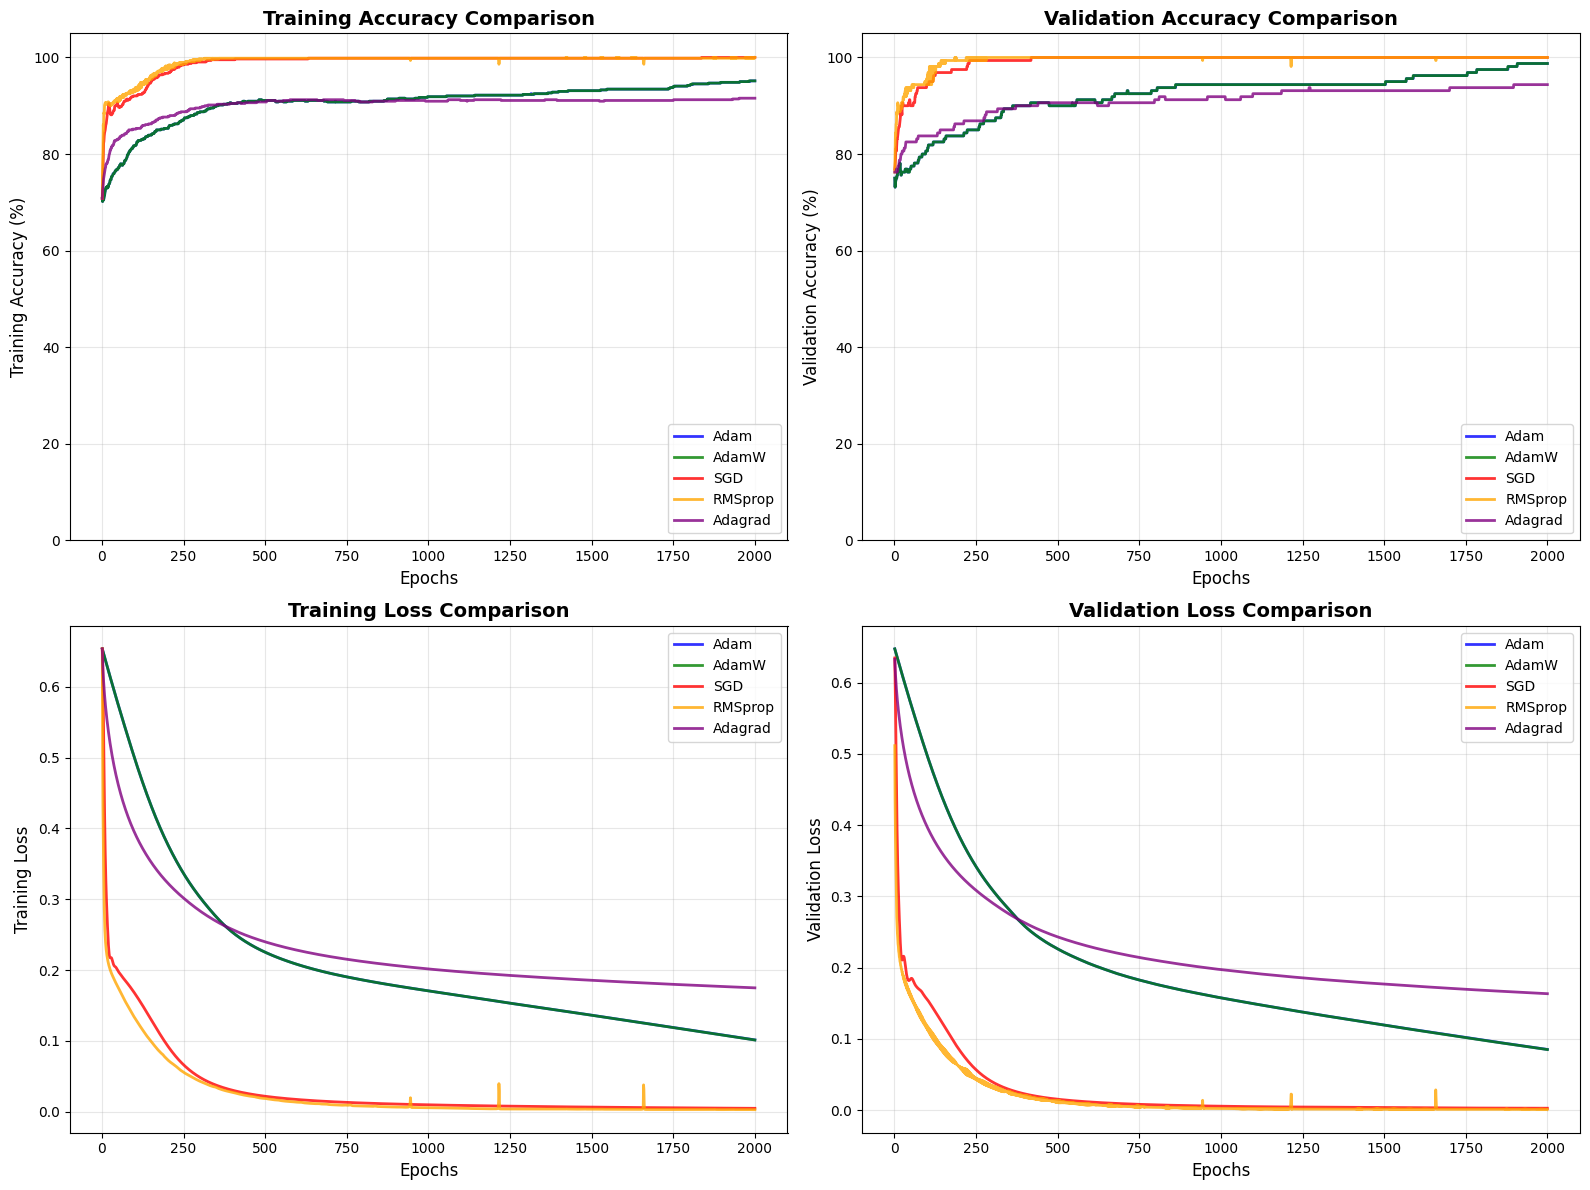

In [36]:
# Create comprehensive learning curve comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Training Accuracy
ax1 = axes[0, 0]
for name, res in results.items():
    ax1.plot(range(1, num_epochs + 1), [acc * 100 for acc in res['train_accs']], 
             label=name, linewidth=2, alpha=0.8, color=res['color'])
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Training Accuracy (%)', fontsize=12)
ax1.set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 105])

# Plot 2: Validation Accuracy
ax2 = axes[0, 1]
for name, res in results.items():
    ax2.plot(range(1, num_epochs + 1), [acc * 100 for acc in res['val_accs']], 
             label=name, linewidth=2, alpha=0.8, color=res['color'])
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 105])

# Plot 3: Training Loss
ax3 = axes[1, 0]
for name, res in results.items():
    ax3.plot(range(1, num_epochs + 1), res['train_losses'], 
             label=name, linewidth=2, alpha=0.8, color=res['color'])
ax3.set_xlabel('Epochs', fontsize=12)
ax3.set_ylabel('Training Loss', fontsize=12)
ax3.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Validation Loss
ax4 = axes[1, 1]
for name, res in results.items():
    ax4.plot(range(1, num_epochs + 1), res['val_losses'], 
             label=name, linewidth=2, alpha=0.8, color=res['color'])
ax4.set_xlabel('Epochs', fontsize=12)
ax4.set_ylabel('Validation Loss', fontsize=12)
ax4.set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 9: Decision Boundary Comparison

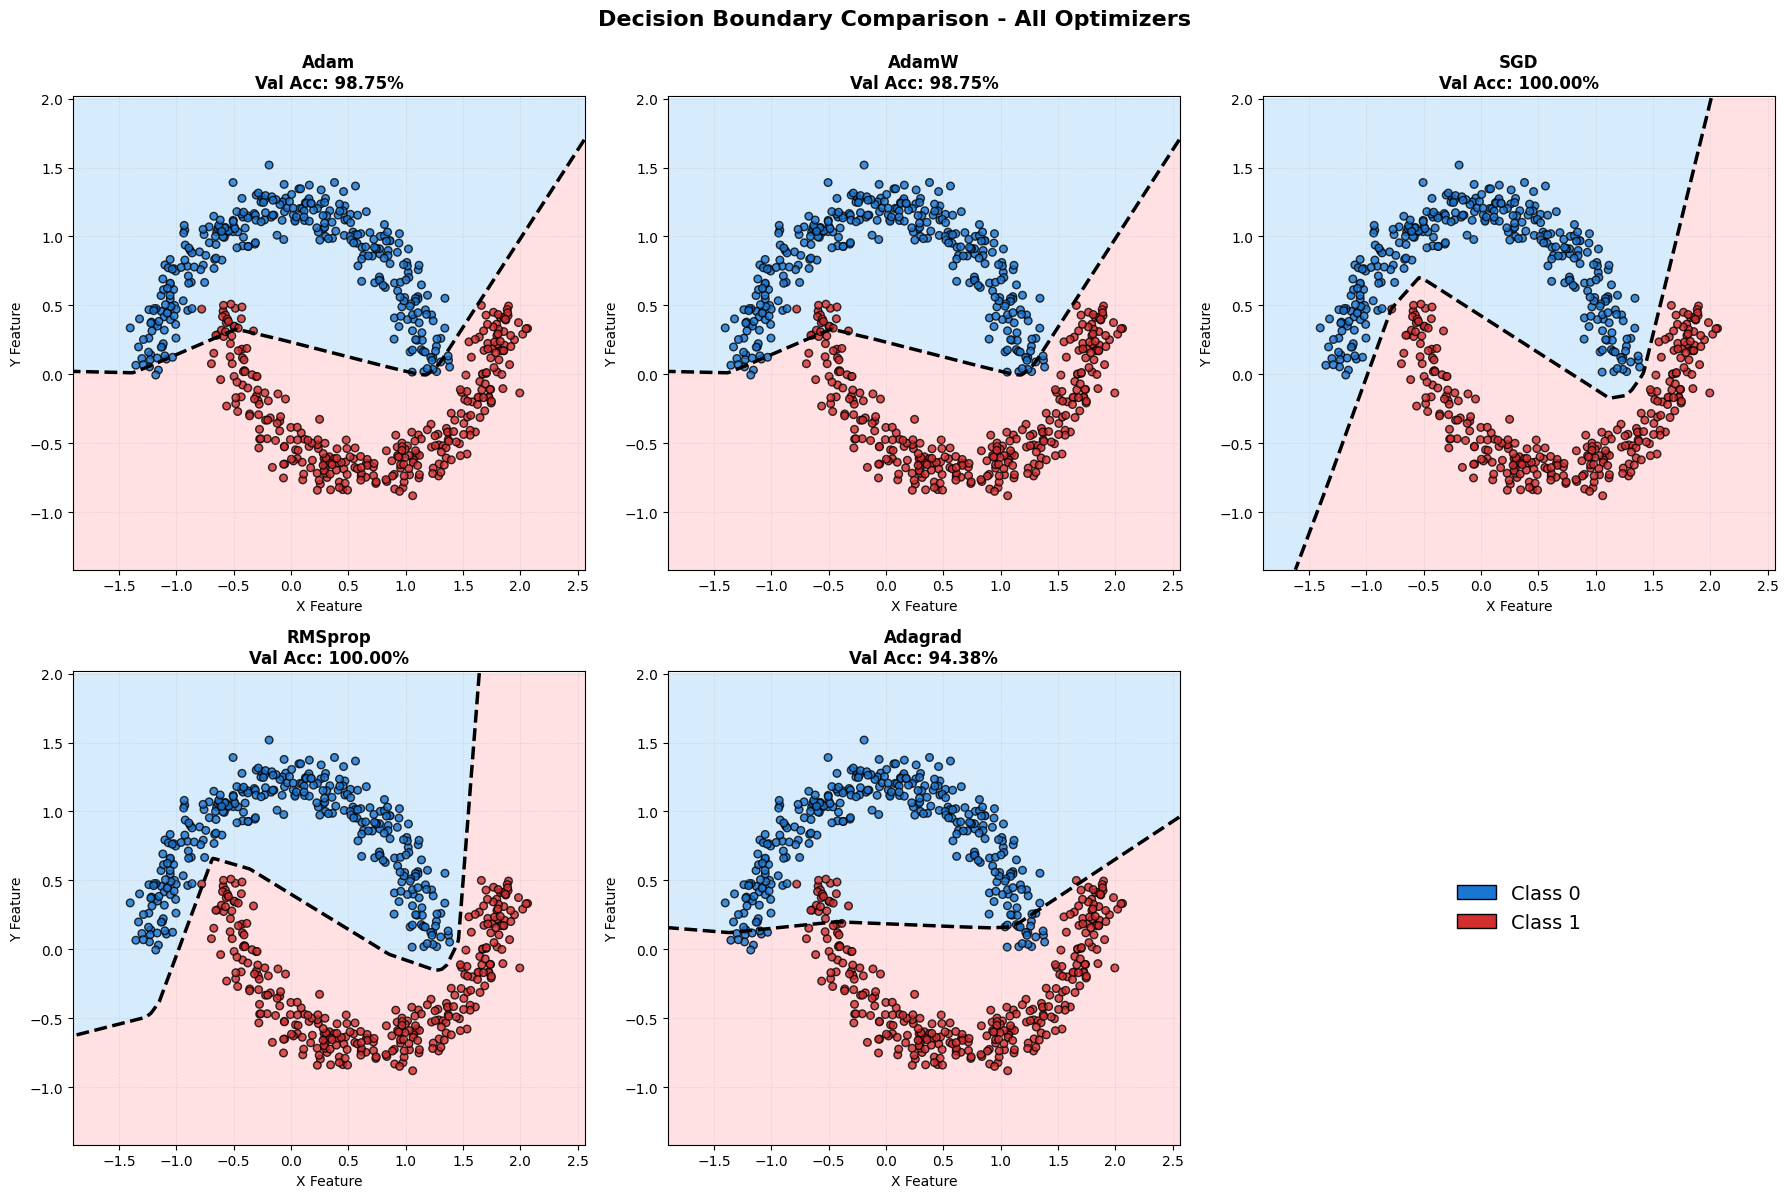

In [37]:

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5 
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
mesh_data = np.c_[xx.ravel(), yy.ravel()]
mesh_tensor = torch.tensor(mesh_data, dtype=torch.float32)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

colors_scatter = ['#1976D2', '#D32F2F']

for idx, (name, res) in enumerate(results.items()):
    ax = axes[idx]
    model = res['model']
    model.eval()
    
    with torch.no_grad():
        Z = model(mesh_tensor).numpy().reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=[0, 0.5, 1], colors=['#BBDEFB', '#FFCDD2'], alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    ax.scatter(X_train[:, 0], X_train[:, 1], 
               c=[colors_scatter[int(label)] for label in y_train],
               edgecolors='black', s=30, alpha=0.8, linewidths=1)
    
    ax.set_xlabel('X Feature', fontsize=10)
    ax.set_ylabel('Y Feature', fontsize=10)
    ax.set_title(f'{name}\nVal Acc: {res["final_val_acc"]*100:.2f}%', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

fig.delaxes(axes[5])

legend_elements = [Patch(facecolor=colors_scatter[0], edgecolor='black', label='Class 0'),
                   Patch(facecolor=colors_scatter[1], edgecolor='black', label='Class 1')]
axes[5] = fig.add_subplot(2, 3, 6)
axes[5].legend(handles=legend_elements, loc='center', fontsize=14, frameon=False)
axes[5].axis('off')

plt.suptitle('Decision Boundary Comparison - All Optimizers', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()
